In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

%matplotlib inline

#plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 200)

## LOAD DATA

In [104]:
train = pd.read_csv('../data/train_ph2_nf_imputed.csv')
test = pd.read_csv('../data/test_clean_cat.csv')
print(train.shape)
print(test.shape)

(91713, 197)
(39308, 183)


In [47]:
set(train.columns)-set(test.columns)

{'added_lbg',
 'apache_3j_diag_int',
 'apache_3j_diag_type',
 'bun_to_creatinine',
 'chronic_diagnosis',
 'critically_ill',
 'd1_lbg',
 'd1_num_labs',
 'd1_ttl_tests',
 'h1_lbg',
 'h1_num_labs',
 'h1_ttl_tests',
 'hospital_death',
 'total_labs_increase',
 'total_tests_increase'}

In [48]:
set(test.columns)-set(train.columns)

{'encounter_id'}

## DATA PREPARATION

In [5]:
# Create variables to store results
search_model = []
search_best_score = []
search_best_estimator= []
search_params_list = []

name_list = []
model_list = []
scores_list = []
recall_list = []
specificity_list = []
precision_list = []
f1_list=[]
roc_list = []

In [6]:
# Create a function to store model performance
# Use standard name:
# X_test, y_test, probs (for predict_proba) 

def model_performance (name, model):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test_ss)).ravel()
    accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    recall    =  tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision =  tp/(tp+fp)
    f1_score  =  (2*precision*recall)/(precision + recall)
    roc = roc_auc_score(y_test,probs)

    name_list.append(name)
    model_list.append(model)
    scores_list.append(accuracy)
    recall_list.append(recall)
    specificity_list.append(specificity)
    precision_list.append(precision)
    f1_list.append(f1_score)
    roc_list.append(roc)
    
    metrics = pd.DataFrame([[name,roc,accuracy,recall,specificity,precision,f1_score]], columns = ['Model Name','ROC_AUC','Accuracy', "Recall", 'Specificity','Precision', 'F1_Score'])
    return metrics

In [7]:
# Create a function to store model performance after RandomizedSearchCV

# Use standard name:
# X_test, y_test, probs (for predict_proba) 

def model_performance_search (name, model):
    
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
    best_model = model.best_estimator_
    
    tn, fp, fn, tp = confusion_matrix(y_test, best_model.predict(X_test_ss)).ravel()
    accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    recall    =  tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision =  tp/(tp+fp)
    f1_score  =  (2*precision*recall)/(precision + recall)
    roc = roc_auc_score(y_test,probs)

    search_model.append(name)
    search_best_score.append(model.best_score_)
    search_best_estimator.append(model.best_estimator_)
    search_params_list.append(model.best_params_)
    
    name_list.append(name)
    model_list.append(model)
    scores_list.append(accuracy)
    recall_list.append(recall)
    specificity_list.append(specificity)
    precision_list.append(precision)
    f1_list.append(f1_score)
    roc_list.append(roc)

    metrics = pd.DataFrame([[name,roc,accuracy,recall,specificity,precision,f1_score]], columns = ['Model Name','ROC_AUC','Accuracy', "Recall", 'Specificity','Precision', 'F1_Score'])
    return metrics


In [8]:
# Apache Variables
apache_cov = ['albumin_apache','bilirubin_apache','bun_apache','creatinine_apache','glucose_apache','heart_rate_apache',
          'hematocrit_apache','resprate_apache','sodium_apache','temp_apache','urineoutput_apache','wbc_apache',
          'fio2_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache']
# 4 indicators
apache_indicators = ['apache_post_operative','arf_apache','intubated_apache','ventilated_apache']

# 8 Chronic health status
apache_chronic = ['aids','cirrhosis','diabetes_mellitus','hepatic_failure',
                  'immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']
# 6 others
apache_others =['apache_2_diagnosis','apache_3j_diagnosis', 'apache_3j_bodysystem','apache_2_bodysystem',
                'apache_4a_hospital_death_prob','apache_4a_icu_death_prob']

gcs = ['gcs_eyes_apache','gcs_motor_apache','gcs_unable_apache','gcs_verbal_apache']

apache = apache_cov + apache_indicators + apache_chronic + apache_others + gcs
len(apache)

40

In [49]:
train.isnull().sum().sort_values(ascending=False)

h1_bilirubin_max        84619
h1_bilirubin_min        84619
h1_lactate_max          84369
h1_lactate_min          84369
h1_albumin_min          83824
                        ...  
apache_2_bodysystem         0
apache_3j_bodysystem        0
added_lbg                   0
gcs_unable_apache           0
hospital_id                 0
Length: 197, dtype: int64

In [10]:
pd.set_option('display.max_columns', 200)
train.head()

,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,apache_3j_diag_int,apache_3j_diag_type,critically_ill,bun_to_creatinine,h1_ttl_tests,d1_ttl_tests,h1_num_labs,d1_num_labs,h1_lbg,d1_lbg,total_tests_increase,total_labs_increase,added_lbg,chronic_diagnosis
0,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,73.9,2.3,113.0,502.01,0,0.0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0.0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,0.05,0.0,0.0,1.0,

### Create independent features X and dependant feature y

In [11]:
# Version 3: Exclude all APACHE covariates, but keep its unique information

#print(len(apache_cov))
#X = train.drop(columns=apache_cov).drop(columns='hospital_death',axis=1)
#y = train.hospital_death

#test = test_m.drop(columns=apache_cov)
#X.shape, test.shape

In [12]:
# Version 2: Exclude all APACHE variables

#print("Apache column to drop:", len(apache))
#X = train.drop(columns = apache).drop(columns = 'hospital_death',axis=1)
#y = train.hospital_death

#test = test.drop(columns = apache)
#X.shape, test.shape

In [105]:
# Original: all Variables
X = train.drop(columns=['hospital_death'])
y = train.hospital_death

## DROP Variables
The following variables will be dropped:
- apache_2_diagnosis - highly correlated to apache_3j_diagnosis
- apache_3j_diagnosis - have alternative features to replace it
- apache_2_bodysystem - highly correlated to apache_3j_bodysystem

In [106]:
cols_to_excl = ['apache_2_diagnosis','apache_3j_diagnosis','apache_2_bodysystem']

In [107]:
X = X.drop(columns = cols_to_excl )
X.shape

(91713, 193)

### Categorical Cols
These are categorical, will need to convert later on:
apache_2_diagnosis,apache_3j_diagnosis,apache_3j_diag_type, hospital_id

In [130]:
X['apache_3j_diag_int'] = X['apache_3j_diag_int'].astype(str)
X['apache_3j_diag_type'].astype(str)

dtype('int64')

In [108]:
categorical_cols = [col for col in X.columns if  (X[col].dtype != 'float64')&(X[col].dtype != 'int64') ]
print(len(categorical_cols))
categorical_cols

7


['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem']

### Encode categorical columns

**For Train dataset**

In [109]:
# Use this if excluding APACHE info
#dummies = pd.get_dummies(X[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU'])

# Use this if APACHE bodysystem is used
dummies = pd.get_dummies(X[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown'])

print(dummies.shape)
X = pd.concat([X.drop(columns=categorical_cols),dummies],axis=1)
X.shape

(91713, 44)


(91713, 230)

**For Test dataset**

In [110]:
# Use this if excluding APACHE info
#dummies = pd.get_dummies(test[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU'])

# Use this if APACHE bodysystem is used
dummies = pd.get_dummies(test[categorical_cols]).drop(columns = ['ethnicity_Other/Unknown','gender_Unknown','hospital_admit_source_Unknown','icu_admit_source_Unknown','icu_stay_type_transfer','icu_type_SICU', 'apache_3j_bodysystem_Unknown'])

print(dummies.shape)
test_m = pd.concat([test.drop(columns=categorical_cols),dummies],axis=1)
test_m = test_m.drop("encounter_id", axis=1)   # Drop encounter_id for test_m dataset to match train here
test_m.shape

(39308, 44)


(39308, 219)

### Remove Columns with more than 75% missing

In [111]:
train_missing = X.isnull().mean().sort_values(ascending = False)
train_missing = train_missing.index[train_missing > 0.75]
#print(train_missing)
X = X.drop(columns = train_missing)

test_m = test_m.drop(columns = train_missing)

print("Feature dimention is: ",X.shape, test_m.shape)

Feature dimention is:  (91713, 185) (39308, 174)


### Impute missing data with SimpleImputer

In [112]:
#imputer = SimpleImputer(strategy = 'mean')
imputer = SimpleImputer(strategy = 'constant', fill_value=0)
X_imputed = imputer.fit_transform(X)
#test_imputed = imputer.fit_transform(test_m)  # Use test's mean to impute

## TRAIN TEST SPLIT

In [113]:
X_train,X_test,y_train,y_test = train_test_split(X_imputed, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(68784, 185) (22929, 185)


## StandardScaler

In [114]:
# Instantiate our StandardScaler.
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)  # Scale X_train.
X_test_ss = ss.transform(X_test)  # Scale X_test.

## OVERSAMPLING THE MINORITY CLASS

In [115]:
y_train.value_counts(normalize=True)

0    0.913701
1    0.086299
Name: hospital_death, dtype: float64

In [116]:
## Oversampling on minority class
sm = SMOTE(k_neighbors=5,sampling_strategy = "minority",random_state=42)
X_sm, y_sm = sm.fit_sample(X_train_ss, y_train)

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [117]:
print(np.bincount(y_train), np.bincount(y_sm))

[62848  5936] [62848 62848]


## MODELING - Logistic Regression

In [118]:
#cv = KFold(n_splits=5, random_state=42, shuffle=False)

cv = StratifiedKFold(n_splits=5, random_state=42)  

C:\Users\dai_f\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### 1. Basic Logistic Regression

In [119]:
### 1. Train Logistic Regression on Oversampling dataset
logr = LogisticRegression(penalty='l1',solver='liblinear',max_iter=200, random_state=42)
logr.fit(X_sm, y_sm)
cross_val_score(logr, X_sm, y_sm, cv=cv, scoring='roc_auc').mean()

0.8869054856911653

In [120]:
# Apply the model to standardized X (not oversampled X)
probs = logr.predict_proba(X_train_ss)[:,1]
pred = logr.predict(X_train_ss)
print("X_train XROC AUC score is:", roc_auc_score(y_train,probs))

y_test_probs = logr.predict_proba(X_test_ss)[:,1]
print("X_test ROC AUC score is:", roc_auc_score(y_test,y_test_probs))

X_train XROC AUC score is: 0.8766418179265184
X_test ROC AUC score is: 0.8765002212973695


In [121]:
print("X_train accuracy:", logr.score(X_train_ss, y_train))
print("X_test accuracy:",logr.score(X_test_ss, y_test))

X_train accuracy: 0.8111770179111422
X_test accuracy: 0.8114178551179728


In [122]:
probs = logr.predict_proba(X_test_ss)[:,1]
fpr,tpr,threshold = roc_curve(y_test,probs)

model_performance("Basic Logistic Regression(impute0)", logr)

,Model Name,ROC_AUC,Accuracy,Recall,Specificity,Precision,F1_Score
0,Basic Logistic Regression(impute0),0.8765,0.811418,0.774634,0.814893,0.283312,0.414885


### 2. Logistic Regression - RandomSearchCV

In [30]:
xnp.logspace(-2,2,10)

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [32]:
# Logistic Regression RandomSearchCV
params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-2,2,10),
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']  # 'newton-cg' - slow for large dataset
                                                     # 'lbfgs' isn't super fast for large dataset
                                                     # liblinear - performs pretty well with high dimensionality
                                                     # sag - Stochastic Average Gradient descent. Fast for big datasets.
                                                     # saga — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.
}

logr = LogisticRegression(random_state=42)
search = RandomizedSearchCV(logr, params,n_iter=50, scoring='roc_auc',cv=cv, verbose=10, n_jobs=-1,random_state=42)
search.fit(X_sm,y_sm)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 24.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 45.9min finished


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=42, test_size=0.25,
            train_size=None),
                   error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm...
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
             

In [33]:
best_logr = search.best_estimator_

In [34]:
probs = best_logr.predict_proba(X_test_ss)[:,1]
fpr,tpr,threshold = roc_curve(y_test,probs)

model_performance_search("Optimized Logistic Regression (drop var)", search)

0.8811573047220126
{'solver': 'liblinear', 'penalty': 'l2', 'C': 100.0}
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


,Model Name,ROC_AUC,Accuracy,Recall,Specificity,Precision,F1_Score
0,Optimized Logistic Regression (drop var),0.878098,0.809891,0.779687,0.812745,0.282291,0.414506


## Performance Summary

In [123]:
results = pd.DataFrame({'model': name_list, 
                        'model_name': model_list,
                        'roc_auc': roc_list,
                        'accuracy': scores_list, 
                        'recall': recall_list, 
                        'specificity': specificity_list,
                        'precision': precision_list,
                        'f1_score': f1_list
                       })

results.to_csv('../data/ph2_logr_results.csv')
               
results

,model,model_name,roc_auc,accuracy,recall,specificity,precision,f1_score
0,Basic Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",0.877936,0.808627,0.779687,0.811360,0.280801,0.412898
1,Optimized Logistic Regression (drop var),RandomizedSearchCV(cv=StratifiedShuffleSplit(n...,0.878098,0.809891,0.779687,0.812745,0.282291,0.414506
2,Basic Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",0.877936,0.808627,0.779687,0.811360,0.280801,0.412898
3,Basic Logistic Regression(impute0),"LogisticRegression(C=1.0, class_weight=None, d...",0.876500,0.811418,0.774634,0.814893,0.283312,0.414885


### ROC Curve

In [124]:
def plot_roc_curve(fpr, tpr,model):
    plt.plot(fpr, tpr, label=model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
#    plt.show()

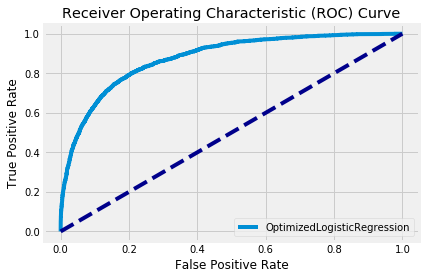

In [125]:
plot_roc_curve(fpr, tpr,'OptimizedLogisticRegression')

In [132]:
logr_curve = pd.DataFrame({'fpr_logr':fpr, 'tpr_logr': tpr, 'thresholds_logr':threshold})
logr_curve.to_csv('../data/roc_curve_logr.csv')

#### Save the model to disk

# save the model to disk
filename = 'logr_randomizedsearchcv.sav'
pickle.dump(best_logr, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)


### Distribution

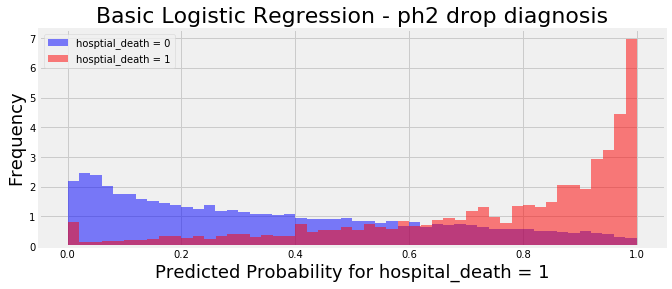

In [126]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':best_logr.predict_proba(X_test_ss)[:,1]})
# Create figure.
plt.figure(figsize = (10,4))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=50,
         color='b',
         alpha = 0.5,
         density=True,
         label='hosptial_death = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=50,
         color='red',
         alpha = 0.5,
         density=True,
         label='hosptial_death = 1')

# Label axes.
plt.title('Basic Logistic Regression - ph2 drop diagnosis', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability for hospital_death = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=10);

### Feature Importance

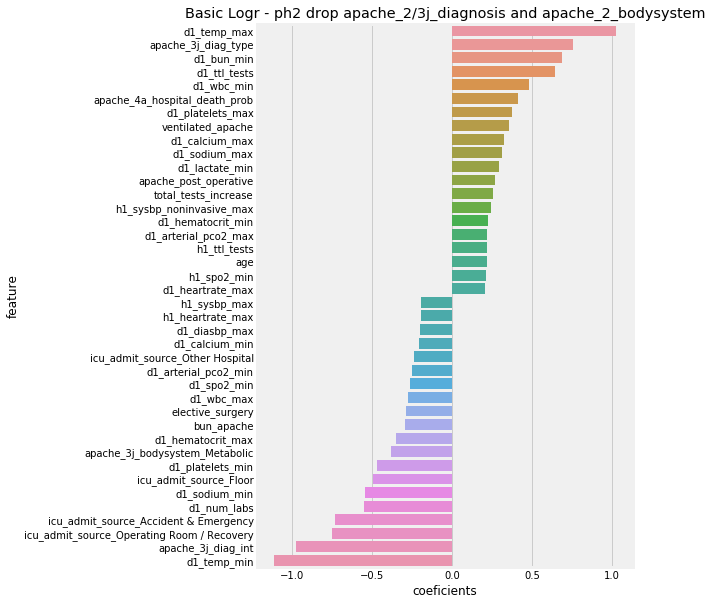

In [128]:
# Display option 1
#feature_imp_df = pd.DataFrame({"feature": X.columns, "coeficients": logr.coef_[0], "coef_abs": abs(logr.coef_[0])}).sort_values(by="coef_abs", ascending=False)
#impt_features = feature_imp_df.head(40)

# Display option 2
feature_imp_df = pd.DataFrame({"feature": X.columns, "coeficients": logr.coef_[0], "coef_abs": abs(logr.coef_[0])}).sort_values(by="coeficients", ascending=False)
impt_features = pd.concat([feature_imp_df.head(20),feature_imp_df.tail(20)])

# The most important features
plt.figure(figsize=(6,10))
sns.barplot(x="coeficients", y="feature", data=impt_features)
plt.title("Basic Logr - ph2 drop apache_2/3j_diagnosis and apache_2_bodysystem")
plt.show()

In [129]:
threshold = 0.02
least_impt = feature_imp_df[feature_imp_df.coef_abs<threshold]
least_impt.sort_values(by='coef_abs')

,feature,coeficients,coef_abs
93,d1_inr_max,0.000000,0.000000
140,chronic_diagnosis,0.000000,0.000000
72,h1_sysbp_noninvasive_min,0.000352,0.000352
145,ethnicity_Native American,-0.001421,0.001421
42,d1_mbp_noninvasive_min,0.001736,0.001736
122,hepatic_failure,-0.001908,0.001908
149,hospital_admit_source_Chest Pain Center,-0.002442,0.002442
123,immunosuppression,0.003302,0.003302
164,icu_admit_source_Other ICU,0.003631,0.003631
124,leukemia,-0.003952,0.003952


## Submission

pred_logr = logr.predict_proba(test_imputed)[:,1]
pred_results = pd.DataFrame({'encounter_id':test_df.encounter_id, 'hospital_death': pred_logr})
pred_results.to_csv('../data/pred_logr.csv',index=False)
pred_results.head()